# U-Net을 이용한 isbi dataset segmentation segmentation

논문 링크 : https://arxiv.org/abs/1505.04597

### [ISBI Dataset](https://imagej.net/events/isbi-2012-segmentation-challenge)
- ISBI(IEEE International Symposium on Biomedical Imaging)에서 제안한 세포막 데이터셋
- label은 신경해부학자에 의해 생성
- size: 512x512
- scale: grayscale
- num of train image: 30
- num of test image: 30
- num of label: 2



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 21 04:18:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## tif를 png로 변환

In [ ]:
import os
os.getcwd()
# os.listdir()

'/content'

In [ ]:
import tifffile as tiff
import skimage.io as io
import os

base_path = "/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net"
os.chdir(base_path)
os.getcwd()

'/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net'

In [ ]:
png_dir_path = os.path.join('isbi_2012', 'png')
png_train_img_dir_path = os.path.join(png_dir_path, 'train_imgs')
png_train_img_dir_path

'isbi_2012/png/train_imgs'

In [ ]:
os.path.exists(png_train_img_dir_path)

True

In [ ]:
# png로 변환한 파일 저장할 곳 지정
png_dir_path = os.path.join('isbi_2012', 'png')
png_train_img_dir_path = os.path.join(png_dir_path, 'train_imgs')
png_train_label_dir_path = os.path.join(png_dir_path, 'train_labels')
png_test_img_dir_path = os.path.join(png_dir_path, 'test_imgs')

# png 저장할 곳이 만들어져 있지 않다면 만들어주기
paths = [png_dir_path,
         png_train_img_dir_path,
         png_train_label_dir_path,
         png_test_img_dir_path]

for path in paths:
  if not os.path.exists(path):
    os.mkdir(path)

# if not os.path.exists(png_train_img_dir_path):
#   if not os.path.exists(png_dir_path):
#     os.mkdir(png_dir_path)
#   os.mkdir(png_train_img_dir_path)
#   os.mkdir(png_train_label_dir_path)
#   os.mkdir(png_test_img_dir_path)

In [ ]:
# .tif 불러올 경로 명시
train_images = tiff.imread(os.path.join('isbi_2012', 'tif_data', 'train-volume.tif'))
train_labels = tiff.imread(os.path.join('isbi_2012', 'tif_data', 'train-labels.tif'))
test_images = tiff.imread(os.path.join('isbi_2012', 'tif_data', 'test-volume.tif'))

print('train img tiff file shape :', train_images.shape)
print('train label tiff file shape :',train_labels.shape)
print('test img tiff file shape :', test_images.shape)

train img tiff file shape : (30, 512, 512)
train label tiff file shape : (30, 512, 512)
test img tiff file shape : (30, 512, 512)


In [ ]:
type(test_images)

numpy.ndarray

In [ ]:
for idx, zip_element in enumerate(zip(train_images, train_labels, test_images)):
  each_train_image, each_train_label, each_test_image = zip_element

  io.imsave(os.path.join(png_train_img_dir_path, f"{idx}.png"), each_train_image)
  io.imsave(os.path.join(png_train_label_dir_path, f"{idx}.png"), each_train_label)
  io.imsave(os.path.join(png_test_img_dir_path, f"{idx}.png"), each_test_image)

print('ISBI 2012 tif to png finished!')

ISBI 2012 tif to png finished!


## 학습용 데이터 생성

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
tf.__version__

'2.14.0'

In [ ]:
def normalize_isbi_2012(input_images, mask_labels):
  # 0~255 값을 0.0~1.0로 변환
  input_images = input_images / 255
  mask_labels = mask_labels / 255

  # label을 binary 형태로 변환
  decision_boundary = 0.5
  mask_labels[mask_labels > decision_boundary] = 1
  mask_labels[mask_labels <= decision_boundary] = 0

  return input_images, mask_labels

In [ ]:
def get_img_gen(directory, classes, batch_size, aug_dict=None):
  img_gen = ImageDataGenerator(**aug_dict)

  return img_gen.flow_from_directory(
      directory='./isbi_2012/png',
      classes = classes,
      class_mode = None, # generator가 label을 함께 반환하지 않도록 설정
      target_size = (512, 512), # png가 512x512
      batch_size = batch_size,
      color_mode='grayscale',
      seed=1
      )


In [ ]:
def make_train_generator(batch_size, aug_dict):
  image_generator = get_img_gen('./isbi_2012/png', ['train_imgs'], batch_size, aug_dict)
  mask_generator = get_img_gen('./isbi_2012/png', ['train_labels'], batch_size, aug_dict)

  train_generator = zip(image_generator, mask_generator)
  for (batch_images, batch_labels) in train_generator:
    batch_images, batch_labels = normalize_isbi_2012(batch_images, batch_labels)

    yield (batch_images, batch_labels)

In [ ]:
# set seed
tf.random.set_seed(1234)

checkpoint_path = os.path.join(base_path, 'saved_model_isbi_2012')
tensorboard_log_path = 'tensorboard_log_isbi_2012'
num_epochs = 5
num_classes = 1
steps_per_epoch=500

# set configuration value
batch_size = 2
learning_rate = 0.0001



In [ ]:
for iter, batch_data in enumerate(train_generator):
    # 두 번째 배치까지만 처리하고 루프 종료
    if iter >= 2:
        break

    # 배치 데이터에서 이미지와 마스크 추출
    batch_image, batch_mask = batch_data[0], batch_data[1]

    # 검사를 위해 현재 배치의 첫 번째 이미지와 마스크 선택
    sample_image, sample_mask = batch_image[0], batch_mask[0]


Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


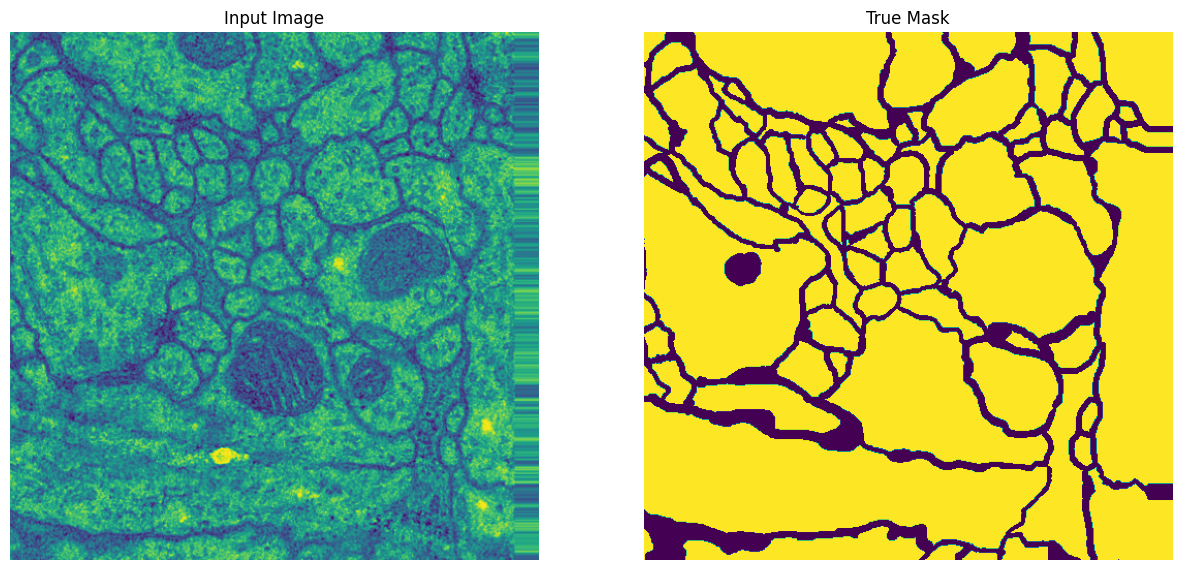

In [ ]:
# display image
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

display([sample_image, sample_mask])

# chioh@chartstudio.kr

## U-Net 모델링

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, concatenate, UpSampling2D

@keras.saving.register_keras_serializable()
class UNET(tf.keras.Model):
    def conv_block(self, input_tensor, filters, kernel_size=3):
        # 논문에서 파란 화살(conv 3x3, ReLU) 부분
        # 원래 논문에서는 padding='valid'로 하여 conv 후 shape이 줄어들지만 여기선 same로 하여 input과 output shape를 맞춤
        # 3x3 conv에 filter 갯수가 filters인
        x = Conv2D(filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(input_tensor)
        x = Conv2D(filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal')(x)
        return x

    def __init__(self, num_classes):
        super(UNET, self).__init__()

        # 입력 레이어
        inputs = Input((512, 512, 1))

        # Contracting 파트
        conv1 = self.conv_block(inputs, 64)
        # 논문에서 빨간 화살(max pool 2x2) 부분
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = self.conv_block(pool1, 128)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = self.conv_block(pool2, 256)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = self.conv_block(pool3, 512)
        # https://arxiv.org/abs/1505.04597
        # 논문 내 3.1 Data Augmentation의 끝부분 내용
        # Drop-out layers at the end of the contracting path perform further implicitdata augmentation
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        # Expansive 파트
        conv5 = self.conv_block(pool4, 1024)
        drop5 = Dropout(0.5)(conv5)

        up6 = self.upconv_block(drop5, drop4, 512)
        conv6 = self.conv_block(up6, 512)

        up7 = self.upconv_block(conv6, conv3, 256)
        conv7 = self.conv_block(up7, 256)

        up8 = self.upconv_block(conv7, conv2, 128)
        conv8 = self.conv_block(up8, 128)

        up9 = self.upconv_block(conv8, conv1, 64)
        conv9 = self.conv_block(up9, 64)
        conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

        conv10 = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

        model = tf.keras.Model(inputs=inputs, outputs=conv10)
        self.model = model

        # 모델 구조 출력
        self.model.summary()

    def upconv_block(self, input_tensor, concat_tensor, filters):
        up = Conv2D(filters, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(input_tensor))
        merged = concatenate([concat_tensor, up], axis=3)
        return merged

    def call(self, x):
        return self.model(x)


In [ ]:
# create ISBI-2012 UNET model
unet_model = UNET(num_classes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

1/1 [==============================] - 9s 9s/step


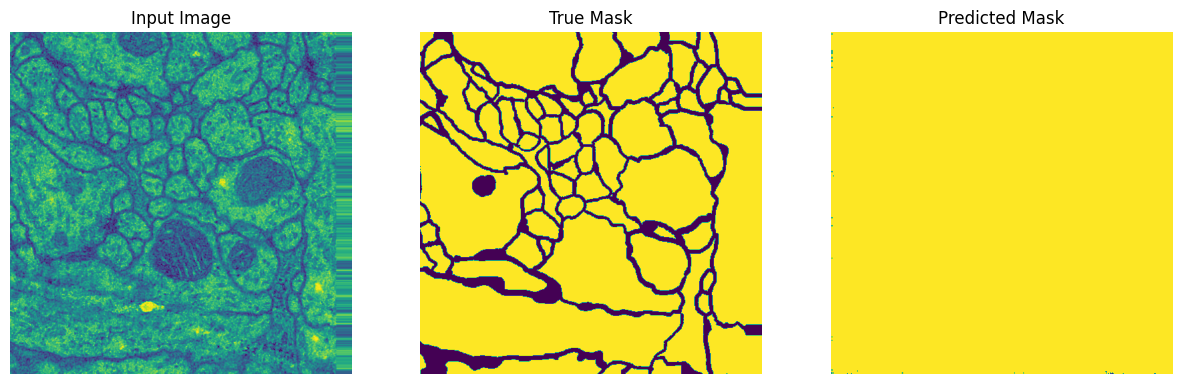

In [ ]:
def create_mask(pred_mask):
  pred_mask = np.where(pred_mask > 0.5, 1, 0)
  return pred_mask[0]

# show prediction
def show_predictions(model, sample_image, sample_mask):
  display([
      sample_image,
      sample_mask,
      create_mask(model.predict(sample_image[tf.newaxis, ...]))
      ])

# show prediction before training
show_predictions(unet_model, sample_image, sample_mask)

In [ ]:
# set optimizer
optimizer = tf.optimizers.Adam(learning_rate)

In [42]:
checkpoint_path

'/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/saved_model_isbi_2012'

In [ ]:
# check if checkpoint path exists
if not os.path.exists(checkpoint_path.split('/')[-2]):
  os.mkdir(checkpoint_path.split('/')[-2])

# restore latest checkpoint
if os.path.isfile(checkpoint_path):
  unet_model.load_weights(checkpoint_path)
  print(f'{checkpoint_path} checkpoint is restored!')

In [ ]:
# display image and save
def display_and_save(display_list, epoch):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.savefig(f'epoch {epoch}.jpg')

In [ ]:
# display and save prediction
def save_predictions(epoch, model, sample_image, sample_mask):
  display_and_save([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))], epoch)

In [ ]:
# set custom callback
# https://www.tensorflow.org/guide/keras/custom_callback?hl=ko
class CustomCallback(tf.keras.callbacks.Callback):
  def __init__(self, unet_model, sample_image, sample_mask):
    super(CustomCallback, self).__init__()
    self.unet_model = unet_model
    self.sample_image = sample_image
    self.sample_mask = sample_mask

  # 훈련 중 epoch가 끝날 때 호출
  def on_epoch_end(self, epoch, logs=None):
    save_predictions(epoch+1, self.unet_model, self.sample_image, self.sample_mask)
    print (f'\n에포크 이후 예측 예시 {epoch+1}\n')

In [ ]:
# set callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_path)
custom_callback = CustomCallback(unet_model, sample_image, sample_mask)

In [ ]:
binary_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
unet_model.compile(
    optimizer = optimizer,
    loss = binary_loss_object,
    metrics = ['accuracy']
    )

In [ ]:
!pip install tensorflow-addons

In [ ]:
# start training
unet_model.fit_generator(train_generator,
                          steps_per_epoch=steps_per_epoch,
                          epochs=num_epochs,
                          callbacks=[
                              model_checkpoint_callback,
                              tensorboard_callback,
                              custom_callback
                              ])

Output hidden; open in https://colab.research.google.com to view.

In [45]:
unet_model.get_weights()[0][0][0]

array([[ 0.54141486,  0.04362935, -0.51498324,  0.22212386,  0.15320364,
        -0.05616258, -0.22618629,  0.59649587, -0.02560614, -0.39519387,
         0.07524774,  0.57406336,  0.53767246,  0.2113483 ,  0.34056196,
        -0.38081288,  0.42647374, -0.6919338 , -0.35048744,  0.25176087,
         0.8655984 , -0.45179057,  0.15868308,  0.03532743,  0.75375086,
        -0.48608014, -0.19509156,  0.58951724,  0.73241013,  0.15444292,
        -0.39712593, -0.7320574 , -0.11913604, -0.3101879 ,  1.0277739 ,
        -0.8385045 ,  0.72082555,  0.30735052,  0.14191596,  0.38708884,
         0.2461757 , -0.38094693, -0.29328418,  0.73035717,  0.23519585,
         0.6934741 ,  0.9335627 , -1.0446491 ,  0.29181758, -0.543759  ,
        -0.8569177 , -0.8633581 ,  0.45209396,  0.33164796, -0.07940762,
         0.38518685,  0.21020089,  0.37199822, -0.16516878, -0.15883845,
        -0.35373572,  0.37054592,  0.6054054 ,  0.28806758]],
      dtype=float32)

In [46]:
# model save
# unet_model.save("./model_save_dir")

## Evalute

In [ ]:
checkpoint_path

'/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/saved_model_isbi_2012'

In [ ]:
if not os.path.exists(checkpoint_path):
    print('checkpoint file is not exists!')

In [75]:
from tensorflow import keras
trained_unet_model = keras.models.load_model(checkpoint_path)

In [80]:
# 직접 학습한 모델과 불러온 모델의 weights가 동일한지 True, False로 체크
(unet_model.get_weights()[0]==trained_unet_model.get_weights()[0]).all()

True

In [55]:
trained_unet_model.summary()

Model: "unet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512, 512, 1)       31031685  
                                                                 
Total params: 31031685 (118.38 MB)
Trainable params: 31031685 (118.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def normalize_isbi_2012(input_images):
  # 0~255 -> 0.0~1.0
  input_images = input_images / 255

  return input_images

def make_test_generator(batch_size):
  image_generator = get_img_gen('./isbi_2012/png', ['test_imgs'], batch_size, aug_dict)

  for batch_images in image_generator:
    batch_images = normalize_isbi_2012(batch_images)

    yield batch_images

batch_size = 1
total_test_image_num = 30

test_generator = make_test_generator(batch_size)
print('total test image :', total_test_image_num)

total test image : 30


In [ ]:
test_dir = 'isbi_2012_test_result'
if not os.path.exists(os.path.join(os.getcwd(), test_dir)):
    os.mkdir(os.path.join(os.getcwd(), test_dir))

In [ ]:
import cv2
from PIL import Image

def create_mask(pred_mask):
  pred_mask = np.where(pred_mask > 0.5, 1, 0)
  x = pred_mask[0][:,:, 0] * 255
  return x.astype(np.uint8)

for image_num, test_image in enumerate(test_generator):
  if image_num >= total_test_image_num:
    break
  pred_mask = trained_unet_model.predict(test_image)
  output_image_path = os.path.join(os.getcwd(), test_dir, f'{image_num}_result.png')
  io.imsave(output_image_path, create_mask(pred_mask))
  print(output_image_path + ' saved!')


Found 30 images belonging to 1 classes.
1/1 [==============================] - 0s 23ms/step
/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/isbi_2012_test_result/0_result.png saved!
1/1 [==============================] - 0s 22ms/step
/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/isbi_2012_test_result/1_result.png saved!
1/1 [==============================] - 0s 20ms/step
/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/isbi_2012_test_result/2_result.png saved!
1/1 [==============================] - 0s 21ms/step
/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/isbi_2012_test_result/3_result.png saved!
1/1 [==============================] - 0s 21ms/step
/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/isbi_2012_test_result/4_result.png saved!
1/1 [==============================] - 0s 20ms/step
/content/drive/MyDrive/teach/2023_multicampus_cnn/u_net/isbi_2012_test_result/5_result.png saved!
1/1 [==============================] - 0s 21ms/step
/content